In [62]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import f1_score

print(tf.__version__)

1.12.0


In [83]:
## Import Data
GENRES_IDX = {"blues":0, "gospel":1, "rap":2, "country":3, "rock":4}
GENRE_NAMES = ["blues", "gospel", "rap", "country", "rock"]

NON_SPARSE_FEATS = ['n_wrds', 'avg_wrd_len',
       'n_lines', 'avg_line_len', 'n_contractions', 'contraction_density',
       'vocab_size', 'edge_density',
       'edge_density_weighted', 'edge_weight_var', 'degree_var',
       'degree_var_weighted', 'degree_avg', 'degree_avg_weighted',
       'comp_size_avg']

SPARSE_FEATS = ['word2vec_avg', 'topk']

NON_SPARSE_FEATS = ['n_wrds', 'avg_wrd_len', 
                   'n_lines', 'avg_line_len', 'n_contractions', 'contraction_density',
                          'vocab_size', 'edge_density',
       'edge_density_weighted', 'edge_weight_var', 'degree_var',
                    'degree_avg', 'degree_avg_weighted', 'comp_size_avg'
                    
                   ]
# NON_SPARSE_FEATS = []

N_NONSPARSE = len(NON_SPARSE_FEATS)

def df_to_arr(df):
    x = df[NON_SPARSE_FEATS]
    x_arr = x.values
    
    y_arr_list = []
    for sparse_feat in SPARSE_FEATS:
        y = df[sparse_feat]
        y_list = [list(y.values[i]) for i in range(y.values.shape[0])]
        y_arr = np.array(y_list)
        y_arr_list.append(y_arr)

    y_arr = y_arr_list[0]
    for i in range(len(y_arr_list) - 1):
        y_arr = np.concatenate((y_arr, y_arr_list[i+1]), axis=1)
    
    # Use one hot encoding labels
    kron = np.eye(5)
    labels = df["genre"].values
    labels_one_hot = np.array([kron[:, GENRES_IDX[genre]] for genre in labels])
    
    # Use integer labels
    labels_sparse = np.array([GENRES_IDX[genre] for genre in labels])
    
    data = np.concatenate((x_arr, y_arr), axis=1)
    return data, labels_sparse

def read_data(fn):
    df = pd.read_pickle(fn)
    df.fillna(0, inplace=True)
    df_train = df.query("data_split == 'train'").copy()
    df_test = df.query("data_split == 'test'").copy()
    df_val = df.query("data_split == 'val'").copy()
    
    X_train, Y_train = df_to_arr(df_train)
    X_val, Y_val = df_to_arr(df_val)
    X_test, Y_test = df_to_arr(df_test)
    
#     ## Standardize Data
#     scaler = preprocessing.StandardScaler().fit(X_train[:, :N_NONSPARSE])
#     X_train[:, :len(NON_SPARSE_FEATS)] = scaler.transform(X_train[:, :N_NONSPARSE])
#     X_val[:, :len(NON_SPARSE_FEATS)] = scaler.transform(X_val[:, :N_NONSPARSE])
#     X_test[:, :len(NON_SPARSE_FEATS)] = scaler.transform(X_test[:, :N_NONSPARSE])
    
#     scaler_sparse = preprocessing.MinMaxScaler().fit(X_train[:, N_NONSPARSE:])
#     X_train[:, len(NON_SPARSE_FEATS):] = scaler_sparse.transform(X_train[:, N_NONSPARSE:])
#     X_val[:, len(NON_SPARSE_FEATS):] = scaler_sparse.transform(X_val[:, N_NONSPARSE:])
#     X_test[:, len(NON_SPARSE_FEATS):] = scaler_sparse.transform(X_test[:, N_NONSPARSE:])
    
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

ALL_DATA_FN = "all.data"
X_train, Y_train, X_val, Y_val, X_test, Y_test = read_data(ALL_DATA_FN)

In [84]:
# Shuffle X_train and Y_train

N = X_train.shape[0]
idx = np.array([i for i in range(N)])
np.random.shuffle(idx)
X_train = X_train[idx]
Y_train = Y_train[idx]

In [85]:
print(X_train.shape)
N_NONSPARSE

(35380, 8001)


13

In [86]:
# Train Model
model = keras.Sequential([
    keras.layers.Dense(200, activation=tf.nn.relu),
    keras.layers.Dense(5, activation=tf.nn.softmax)
])

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
  # Interrupt training if `val_loss` stops improving for over 2 epochs
  tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
  # Write TensorBoard logs to `./logs` directory
  tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

# SHUFFLE THE DATA
model_fitted = model.fit(X_train, Y_train, 
                         epochs=100, 
                         validation_data = (X_val, Y_val), 
                         batch_size=32, 
                         callbacks=callbacks
                        )

# Evaluate Model
model.evaluate(X_test, Y_test, batch_size=32)

Train on 35380 samples, validate on 11851 samples
Epoch 1/100
35380/35380 [==============================] - 12s 346us/step - loss: 1.1467 - acc: 0.5741 - val_loss: 0.8971 - val_acc: 0.6540
Epoch 2/100
35380/35380 [==============================] - 11s 307us/step - loss: 0.8918 - acc: 0.6653 - val_loss: 0.8130 - val_acc: 0.6961
Epoch 3/100
35380/35380 [==============================] - 12s 345us/step - loss: 0.8160 - acc: 0.6942 - val_loss: 0.8070 - val_acc: 0.6941
Epoch 4/100
35380/35380 [==============================] - 11s 304us/step - loss: 0.7604 - acc: 0.7148 - val_loss: 1.0690 - val_acc: 0.5847
Epoch 5/100
11730/11730 [==============================] - 2s 138us/step


[0.8182419971633585, 0.7007672634067844]

In [5]:
X = X_val
Y = Y_val

Y_hat = model.predict(X)
Y_pred = np.argmax(Y_hat, axis=1)

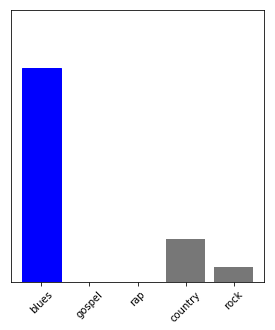

In [34]:
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(5), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')
    
i = 4
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_value_array(i, Y_hat,  Y)
_ = plt.xticks(range(5), GENRE_NAMES, rotation=45)

Confusion matrix, without normalization
[[ 768   32    7  317  346]
 [  37 1254   62  310  159]
 [  23   18 2044   42   60]
 [ 182  184   22 2465  409]
 [ 283  158   67  777 1825]]
Normalized confusion matrix
[[0.52 0.02 0.   0.22 0.24]
 [0.02 0.69 0.03 0.17 0.09]
 [0.01 0.01 0.93 0.02 0.03]
 [0.06 0.06 0.01 0.76 0.13]
 [0.09 0.05 0.02 0.25 0.59]]


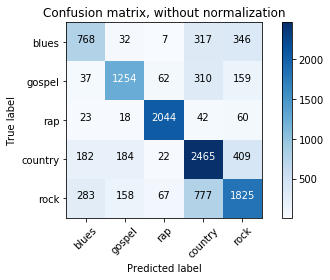

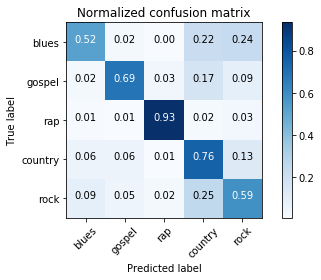

In [35]:
## Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(Y, Y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=GENRE_NAMES,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=GENRE_NAMES, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [48]:
print(GENRE_NAMES)
f1_score(Y, Y_pred, average=None)


['blues', 'gospel', 'rap', 'country', 'rock']


array([0.56, 0.72, 0.93, 0.69, 0.62])

array([0, 0, 0, ..., 4, 4, 4])